# Basic functionality

In this notebook we demonstrate the basic usage of the MICROtool package. The main usage of MICROtool is to optimize a diffusion imaging acquisition scheme based on a microstructural model. In order to do so the steps to follow are
1. Setup a tissue model
2. Setup an acquisition scheme (it is recommended to choose an initial scheme that already is a sensible choice for your problem)
3. Optimize the scheme using cramer rao lower bound based optimization.
4. (optional) Verify the resulting scheme using monte carlo simulations.


## Setting up the dmipy model

We demonstrate this using a simple model from dmipy

In [1]:
import numpy as np
from dmipy.signal_models.gaussian_models import G1Ball
from microtool.dmipy import DmipyMultiTissueModel

# Setup up a simple model in dmipy, where lambda_iso represents the diffusivity.
simple_ball_dmipy = G1Ball(lambda_iso=1.7e-9)

# Convert it to a MICROtool compatible model.
simple_ball_microtool = DmipyMultiTissueModel(simple_ball_dmipy)

## Setting up the acquisition scheme

In [2]:
from microtool.acquisition_scheme import DiffusionAcquisitionScheme
from microtool.gradient_sampling import sample_uniform_half_sphere


n_directions = 6  # Number of b-vectors per shell
n_shells = 3  # Number of shells

b_vals = np.concatenate([np.repeat(0, n_directions), np.repeat(1000, n_directions), np.repeat(3000, n_directions)])
pulse_durations = np.concatenate([np.repeat(0.019, n_directions), np.repeat(0.016, n_directions), np.repeat(0.007, n_directions)])
pulse_intervals = np.concatenate([np.repeat(0.030, n_directions), np.repeat(0.027, n_directions), np.repeat(0.020, n_directions)])

directions = sample_uniform_half_sphere(n_directions * n_shells)
initial_scheme = DiffusionAcquisitionScheme.from_bvals(b_values=b_vals,
                                                       b_vectors=directions,
                                                       pulse_durations=pulse_durations,
                                                       pulse_intervals=pulse_intervals)

initial_scheme.fix_b0_measurements()
initial_scheme["EchoTime"].fixed = True  # Don't optimize the echo time, but keep it fixed to the given value.
print(initial_scheme)

Acquisition scheme with 18 measurements and 6 scalar parameters. 
total number of optimized parameters is 36:
  DiffusionPulseMagnitude [mT/mm] in (0.0, 5000.0)    DiffusionGradientAnglePhi [rad] (fixed)    DiffusionGradientAngleTheta [rad] (fixed)    DiffusionPulseDuration [s] in (0.001, 0.1)    DiffusionPulseInterval [s] in (0.001, 0.1)    EchoTime [s] (fixed)
--------------------------------------------------  -----------------------------------------  -------------------------------------------  --------------------------------------------  --------------------------------------------  ----------------------
                                        -0                                          -1.27224                                     1.5708                                            0.019                                         0.03                0.0349249
                                        -0                                          -2.41504                                 

Now that we have the acquisition scheme and tissue model defined we test the generation of signal.

In [3]:
simple_ball_microtool(initial_scheme)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.18268352, 0.18268352, 0.18268352, 0.18268352,
       0.18268352, 0.18268352, 0.00609675, 0.00609675, 0.00609675,
       0.00609675, 0.00609675, 0.00609675])

## Optimizing the scheme with respect to the diffusivity

In [4]:
from microtool.optimize import optimize_scheme

optimal_scheme, _ = optimize_scheme(initial_scheme, simple_ball_microtool, noise_variance=0.02, method="trust-constr", solver_options={"verbose":2, "maxiter": 30})

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |  37   |   0   | +9.8889e-02 | 1.00e+00 | 5.60e-02 | 0.00e+00 |
|   2   |  37   |   0   | +9.8889e-02 | 5.00e+00 | 1.12e-02 | 0.00e+00 |


C:\develop\microtool\venv\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


|   3   |  74   |   4   | +9.8748e-02 | 3.50e+01 | 1.12e-02 | 0.00e+00 |
|   4   |  111  |   9   | +9.7851e-02 | 7.00e+01 | 1.01e-02 | 0.00e+00 |
|   5   |  148  |  15   | +5.4384e-02 | 7.00e+01 | 1.30e-02 | 0.00e+00 |
|   6   |  148  |  15   | +5.4384e-02 | 3.50e+02 | 4.32e-03 | 0.00e+00 |
|   7   |  185  |  22   | +5.5778e-02 | 3.50e+02 | 1.48e-03 | 0.00e+00 |
|   8   |  222  |  32   | +4.0704e-02 | 3.50e+02 | 1.87e-03 | 0.00e+00 |
|   9   |  259  |  43   | +3.9145e-02 | 3.50e+02 | 2.19e-03 | 0.00e+00 |
|  10   |  296  |  54   | +3.7646e-02 | 3.50e+02 | 1.89e-03 | 0.00e+00 |
|  11   |  333  |  65   | +3.6947e-02 | 3.50e+02 | 2.30e-03 | 0.00e+00 |
|  12   |  333  |  65   | +3.6947e-02 | 1.75e+03 | 8.04e-04 | 0.00e+00 |
|  13   |  370  |  86   | +3.6898e-02 | 1.75e+03 | 5.03e-04 | 0.00e+00 |
|  14   |  407  |  98   | +3.5884e-02 | 1.75e+03 | 5.47e-04 | 0.00e+00 |
|  15   |  407  |  98   | +3.5884e-02 | 8.75e+03 | 2.56e-04 | 0.00e+00 |
|  16   |  444  |  114  | +3.5611e-02 | 8.75e+03 | 

C:\develop\microtool\microtool\optimize\optimize.py:246: UserWarning: Optimization procedure was unsuccessful. Possible solutions include but are not limited to: Changing the optimizer settings, changing the optimization method or changing the initial scheme to a more suitable one. If you are using a scipy optimizer its settings can be changed by passing options to this function. If you are using a MICROtool optimization method please consult the optimization_methods module for more details.
  warnings.warn(


In [9]:
print(optimal_scheme)

Acquisition scheme with 18 measurements and 6 scalar parameters. 
total number of optimized parameters is 36:
  DiffusionPulseMagnitude [mT/mm] in (0.0, 5000.0)    DiffusionGradientAnglePhi [rad] (fixed)    DiffusionGradientAngleTheta [rad] (fixed)    DiffusionPulseDuration [s] in (0.001, 0.1)    DiffusionPulseInterval [s] in (0.001, 0.1)    EchoTime [s] (fixed)
--------------------------------------------------  -----------------------------------------  -------------------------------------------  --------------------------------------------  --------------------------------------------  ----------------------
                                        -0                                          -1.27224                                     1.5708                                       0.019                                          0.03                    0.0349249
                                        -0                                          -2.41504                                 

## Fitting the model

In [5]:
# Generating basic signal on the new scheme
signal = simple_ball_microtool(optimal_scheme)

fitted_model = simple_ball_microtool.fit(optimal_scheme, signal, use_parallel_processing=False)
fitted_model.fitted_parameters

Setup brute2fine optimizer in 0.0010113716125488281 seconds
Fitting of 1 voxels complete in 0.5314667224884033 seconds.
Average of 0.5314667224884033 seconds per voxel.


{'G1Ball_1_lambda_iso': array([1.69997281e-09])}

## Starting an experiment

This is an optional step to initiate some directories

In [6]:
from microtool.monte_carlo.IO import make_expirement_directories
from pathlib import Path

# make an expirement directory in the current execution directory
_, _, simdir, _ = make_expirement_directories(Path.cwd(), "basic_output")

C:\develop\microtool\microtool\monte_carlo\IO.py:38: UserWarning: There is already a folder with the name of the experiment. No new folders have been created.
  warnings.warn("There is already a folder with the name of the experiment. No new folders have been created.")


## Validation of scheme optimization through Monte Carlo simulations

What we want to do now is verify that our scheme increase the accuracy with which we can fit the parameters of our tissue model. To do so we run monte carlo simulations both with the scheme we started out with and the scheme resulting from the optimization.

In [7]:
from microtool.monte_carlo.simulation import MonteCarloSimulation
from scipy import stats

# loc is mean and scale is standard deviation
noise_distribution = stats.norm(loc=0, scale=0.02)

# Perform a Monte Carlo simulation using the initial scheme.
simulation = MonteCarloSimulation(initial_scheme, simple_ball_microtool, noise_distribution, n_sim=100)
simulation.run()
simulation.save(simdir / "initial.pkl")

# Repeat the simulation using the optimized scheme.
simulation.set_scheme(optimal_scheme)
simulation.run()
simulation.save(simdir / "optimal.pkl")

Starting Monte Carlo with 100 simulations: 100%|██████████| 100/100 [07:58<00:00,  4.79s/it]


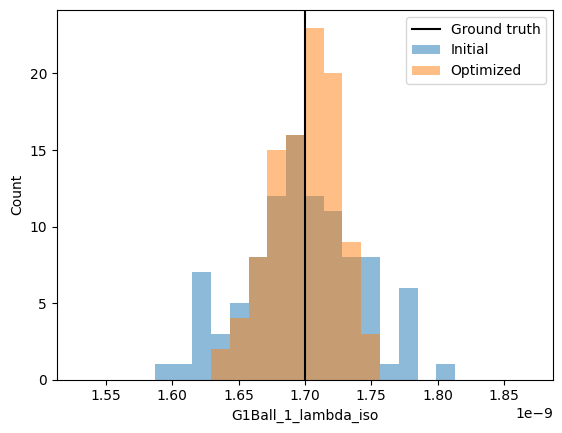

In [8]:
from matplotlib import pyplot as plt
from microtool.utils.IO import get_pickle


initial_result = get_pickle(simdir / "initial.pkl")
optimal_result = get_pickle(simdir / "optimal.pkl")

for name, parameter in simple_ball_microtool.items():
    if parameter.optimize:
        bins = np.linspace(0.9 * parameter.value, 1.1 * parameter.value, 25)
        plt.figure()
        plt.axvline(x=parameter.value, color="black")
        plt.hist(initial_result[name], bins=bins, alpha = 0.5)
        plt.hist(optimal_result[name], bins=bins, alpha = 0.5)
        plt.xlabel(name)
        plt.ylabel("Count")
        plt.legend(["Ground truth", "Initial", "Optimized"])